[sigmoid] epoch    0  loss=0.706109  acc=0.50
[sigmoid] epoch  500  loss=0.672558  acc=0.75
[sigmoid] epoch 1000  loss=0.313283  acc=1.00
[sigmoid] epoch 1500  loss=0.047529  acc=1.00
[sigmoid] epoch 2000  loss=0.022343  acc=1.00
[sigmoid] epoch 2500  loss=0.014359  acc=1.00
[sigmoid] epoch 3000  loss=0.010519  acc=1.00
[sigmoid] epoch 3500  loss=0.008278  acc=1.00
[sigmoid] epoch 4000  loss=0.006814  acc=1.00
[sigmoid] epoch 4500  loss=0.005785  acc=1.00
[sigmoid] epoch 4999  loss=0.005024  acc=1.00
[tanh  ] epoch    0  loss=0.712969  acc=0.50
[tanh  ] epoch  500  loss=0.021333  acc=1.00
[tanh  ] epoch 1000  loss=0.007978  acc=1.00
[tanh  ] epoch 1500  loss=0.004868  acc=1.00
[tanh  ] epoch 2000  loss=0.003495  acc=1.00
[tanh  ] epoch 2500  loss=0.002723  acc=1.00
[tanh  ] epoch 3000  loss=0.002230  acc=1.00
[tanh  ] epoch 3500  loss=0.001887  acc=1.00
[tanh  ] epoch 4000  loss=0.001635  acc=1.00
[tanh  ] epoch 4500  loss=0.001442  acc=1.00
[tanh  ] epoch 4999  loss=0.001291  acc=1.00

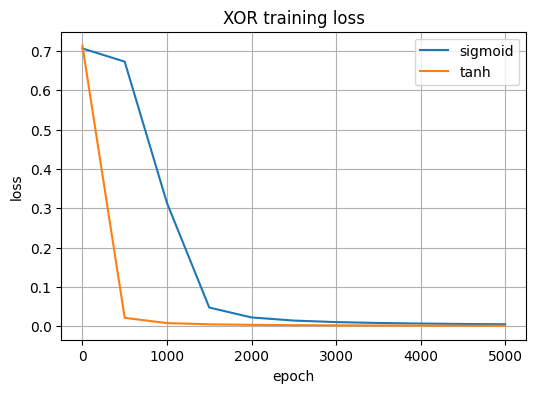

Saved weights to: XOR_solved.w


In [7]:
# === Colab-ready: Tiny NN library + XOR training & saving weights ===
import numpy as np
import matplotlib.pyplot as plt

# --------------------------
# Core layer abstractions
# --------------------------
class Layer:
    def forward(self, x):
        raise NotImplementedError
    def backward(self, grad_out):
        raise NotImplementedError
    @property
    def params(self):  # name -> ndarray
        return {}
    @property
    def grads(self):   # name -> ndarray
        return {}

class Linear(Layer):
    """
    Fully-connected layer: y = x W^T + b
    Shapes:
      x: (N, D), W: (H, D), b: (H,), out: (N, H)
    """
    def __init__(self, in_features, out_features, weight_scale=0.01, seed=None):
        if seed is not None:
            rng = np.random.default_rng(seed)
            self.W = rng.standard_normal((out_features, in_features)) * weight_scale
        else:
            self.W = np.random.randn(out_features, in_features) * weight_scale
        self.b = np.zeros(out_features, dtype=float)
        self.x = None
        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b)

    def forward(self, x):
        self.x = x
        return x @ self.W.T + self.b

    def backward(self, grad_out):
        # grad_out: (N, H)
        self.dW = grad_out.T @ self.x              # (H,N)@(N,D) -> (H,D)
        self.db = grad_out.sum(axis=0)             # (H,)
        grad_x  = grad_out @ self.W                # (N,H)@(H,D) -> (N,D)
        return grad_x

    @property
    def params(self): return {"W": self.W, "b": self.b}
    @property
    def grads(self):  return {"W": self.dW, "b": self.db}

class Sigmoid(Layer):
    def __init__(self):
        self.y = None
    def forward(self, x):
        self.y = 1.0 / (1.0 + np.exp(-x))
        return self.y
    def backward(self, grad_out):
        return grad_out * self.y * (1.0 - self.y)

class Tanh(Layer):
    def __init__(self):
        self.y = None
    def forward(self, x):
        self.y = np.tanh(x)
        return self.y
    def backward(self, grad_out):
        return grad_out * (1.0 - self.y**2)

class ReLU(Layer):
    def __init__(self):
        self.mask = None
    def forward(self, x):
        self.mask = (x > 0).astype(x.dtype)
        return x * self.mask
    def backward(self, grad_out):
        return grad_out * self.mask

# --------------------------
# Loss: Binary Cross-Entropy
# --------------------------
class BinaryCrossEntropy:
    """
    Forward returns scalar mean loss.
    Backward returns dJ/dy_pred (same shape as y_pred).
    """
    def __init__(self, eps=1e-12):
        self.eps = eps
        self.y_pred = None
        self.y_true = None

    def forward(self, y_pred, y_true):
        y_pred = np.clip(y_pred, self.eps, 1.0 - self.eps)
        self.y_pred, self.y_true = y_pred, y_true
        loss = -(y_true*np.log(y_pred) + (1-y_true)*np.log(1-y_pred))
        return float(loss.mean())

    def backward(self):
        N = self.y_true.shape[0]
        grad = (-(self.y_true / self.y_pred) + (1 - self.y_true) / (1 - self.y_pred)) / N
        return grad

# --------------------------
# Model container
# --------------------------
class Sequential(Layer):
    def __init__(self, *layers):
        self.layers = list(layers)

    def add(self, layer):
        self.layers.append(layer)

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, grad_out):
        for layer in reversed(self.layers):
            grad_out = layer.backward(grad_out)
        return grad_out

    def parameters_and_grads(self):
        for layer in self.layers:
            for name, param in getattr(layer, "params", {}).items():
                grad = layer.grads[name]
                yield param, grad

# --------------------------
# Optimizer: tiny SGD step
# --------------------------
def sgd_step(model, lr=0.1):
    for param, grad in model.parameters_and_grads():
        param -= lr * grad

# --------------------------
# Save weights
# --------------------------
import io, zipfile

def save_model_npz_noext(model, path="XOR_solved.w", compressed=True):
    """
    Writes NumPy .npz archive into a file named exactly `path`
    (no automatic .npz suffix). This satisfies the assignment's filename.
    """
    blobs, i = {}, 0
    for layer in model.layers:
        for name, param in getattr(layer, "params", {}).items():
            blobs[f"L{i}_{name}"] = param
        i += 1

    # Build npz in-memory to avoid auto extension
    mem = io.BytesIO()
    # Minimal npz writer
    with zipfile.ZipFile(mem, mode="w", compression=(zipfile.ZIP_DEFLATED if compressed else zipfile.ZIP_STORED)) as zf:
        for k, arr in blobs.items():
            # .npy payload for each array
            with io.BytesIO() as buf:
                np.save(buf, arr)
                zf.writestr(k + ".npy", buf.getvalue())
    with open(path, "wb") as f:
        f.write(mem.getvalue())

# --------------------------
# XOR training utility
# --------------------------
def train_xor(hidden_activation="sigmoid", lr=0.5, epochs=5000, seed=42, verbose=True):
    rng = np.random.default_rng(seed)
    # XOR data
    X = np.array([[0,0],[0,1],[1,0],[1,1]], dtype=float)
    y = np.array([[0],[1],[1],[0]], dtype=float)

    # build model: 2 -> 2 -> 1 with chosen hidden activation
    hidden = Sigmoid() if hidden_activation.lower()=="sigmoid" else Tanh()
    model = Sequential(
        Linear(2, 2, weight_scale=0.5, seed=rng.integers(1e9)),
        hidden,
        Linear(2, 1, weight_scale=0.5, seed=rng.integers(1e9)),
        Sigmoid(),  # output prob for BCE
    )
    loss_fn = BinaryCrossEntropy()

    hist = {"epoch": [], "loss": [], "acc": []}
    for epoch in range(epochs):
        # forward
        y_pred = model.forward(X)
        loss = loss_fn.forward(y_pred, y)

        # backward
        grad_out = loss_fn.backward()
        model.backward(grad_out)

        # update
        sgd_step(model, lr=lr)

        if verbose and (epoch % 500 == 0 or epoch == epochs-1):
            preds = (y_pred > 0.5).astype(int)
            acc = float((preds == y).mean())
            hist["epoch"].append(epoch); hist["loss"].append(loss); hist["acc"].append(acc)
            print(f"[{hidden_activation:6s}] epoch {epoch:4d}  loss={loss:.6f}  acc={acc:.2f}")

    # final metrics
    preds = (y_pred > 0.5).astype(int)
    final_acc = float((preds == y).mean())
    return model, np.array(hist["epoch"]), np.array(hist["loss"]), np.array(hist["acc"]), final_acc

# --------------------------
# Run both: sigmoid vs tanh; plot; save best -> XOR_solved.w
# --------------------------
model_sig, e_sig, l_sig, a_sig, acc_sig = train_xor("sigmoid", lr=0.5, epochs=5000, seed=42)
model_tanh, e_tn,  l_tn,  a_tn,  acc_tn  = train_xor("tanh",    lr=0.5, epochs=5000, seed=42)

print("\nFinal accuracy — sigmoid:", acc_sig, " | tanh:", acc_tn)

# Plot loss curves
plt.figure(figsize=(6,4))
plt.plot(e_sig, l_sig, label="sigmoid")
plt.plot(e_tn,  l_tn,  label="tanh")
plt.xlabel("epoch"); plt.ylabel("loss"); plt.title("XOR training loss")
plt.legend(); plt.grid(True); plt.show()

# Save the better model as XOR_solved.w (exact filename, no extra suffix)
best_model = model_tanh if l_tn[-1] <= l_sig[-1] else model_sig
save_model_npz_noext(best_model, "XOR_solved.w", compressed=True)
print("Saved weights to: XOR_solved.w")


In [8]:
from google.colab import files
uploaded = files.upload()

Saving nyc_taxi_data.npy to nyc_taxi_data.npy


{'X_train': <class 'pandas.core.frame.DataFrame'>, 'X_test': <class 'pandas.core.frame.DataFrame'>, 'y_train': <class 'pandas.core.series.Series'>, 'y_test': <class 'pandas.core.series.Series'>}
Train DF: (1312779, 10)  Test DF: (145865, 10)
y_train: (1312779,)  y_test: (145865,)

Selected 3 features: ['pickup_latitude', 'dropoff_latitude', 'pickup_longitude']
X_train:(1312779, 3), X_test:(145865, 3)
 Final sets → X_train:(1050224, 3), X_val:(262555, 3), X_test:(145865, 3)

 Training Model_1 → [(64, 'tanh')] | lr=0.003
Epoch 1/30
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 3.2487 - val_loss: 0.7074
Epoch 2/30
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.6886 - val_loss: 0.6550
Epoch 3/30
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.6354 - val_loss: 0.6056
Epoch 4/30
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.5985 - val_loss: 0.5926
Epoch 5/30
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.5861 - val_loss: 0.5892
Epoch 6/30
1026/1026 ━━━━━━━━━━━━━━

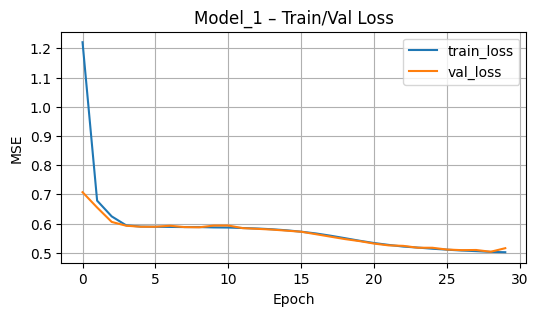


 Model_1 → MSE=0.5070 | MAE=0.5258 | R2=0.2059

 Training Model_2 → [(128, 'relu'), (64, 'relu')] | lr=0.001
Epoch 1/30
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 5.2468 - val_loss: 0.4979
Epoch 2/30
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.4666 - val_loss: 0.4093
Epoch 3/30
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.4019 - val_loss: 0.3893
Epoch 4/30
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.3963 - val_loss: 0.3784
Epoch 5/30
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.3859 - val_loss: 0.3937
Epoch 6/30
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.3767 - val_loss: 0.3716
Epoch 7/30
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.3760 - val_loss: 0.3850
Epoch 8/30
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.3729 - val_loss: 0.3666
Epoch 9/30
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.3702 - val_loss: 0.3668
Epoch 10/30
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.3686 - val_loss: 0.3634
Epoch 11/

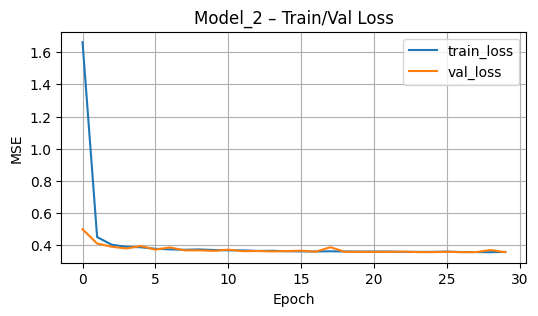


 Model_2 → MSE=0.3585 | MAE=0.4264 | R2=0.4385

 Training Model_3 → [(256, 'relu'), (128, 'relu'), (64, 'relu')] | lr=0.0005
Epoch 1/30
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 5.8928 - val_loss: 0.4739
Epoch 2/30
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.4474 - val_loss: 0.4032
Epoch 3/30
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.4073 - val_loss: 0.3827
Epoch 4/30
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.3882 - val_loss: 0.3780
Epoch 5/30
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.3766 - val_loss: 0.3730
Epoch 6/30
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.3697 - val_loss: 0.3729
Epoch 7/30
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.3662 - val_loss: 0.3682
Epoch 8/30
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.3667 - val_loss: 0.3665
Epoch 9/30
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.3638 - val_loss: 0.3665
Epoch 10/30
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss:

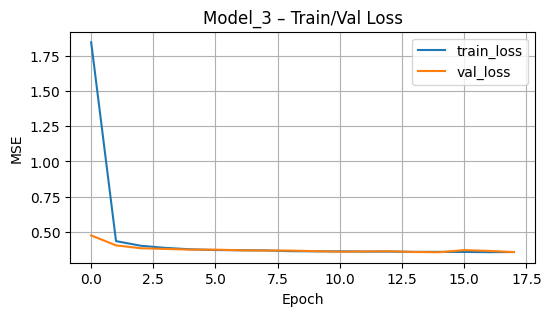


 Model_3 → MSE=0.3581 | MAE=0.4269 | R2=0.4392


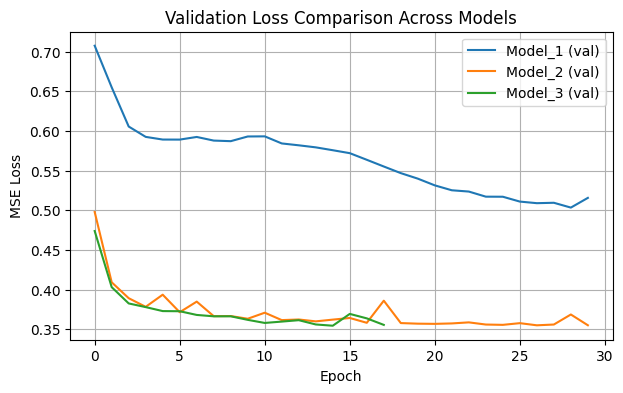


Model Comparison Summary


,Model,MSE,MAE,R2
0,Model_1,0.506987,0.525781,0.205935
1,Model_2,0.358517,0.426393,0.438475
2,Model_3,0.358081,0.426935,0.439159



 Best Model:
Model     Model_3
MSE      0.358081
MAE      0.426935
R2       0.439159
Name: 2, dtype: object


In [12]:
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt

# 0) Load Canvas dataset (adjust PATH if your filename differs)
PATH = "/content/nyc_taxi_data.npy"
assert os.path.exists(PATH), f"File not found: {PATH}"
dataset = np.load(PATH, allow_pickle=True).item()
X_train_df, X_test_df = dataset["X_train"], dataset["X_test"]
y_train_sr, y_test_sr = dataset["y_train"], dataset["y_test"]

print({k:type(v) for k,v in dataset.items()})
print(f"Train DF: {X_train_df.shape}  Test DF: {X_test_df.shape}")
print(f"y_train: {y_train_sr.shape}  y_test: {y_test_sr.shape}")

# 1) Numeric-only baseline, align columns
def numeric_only(df: pd.DataFrame) -> pd.DataFrame:
    out = df.select_dtypes(include=[np.number]).copy()
    out = out.fillna(out.median(numeric_only=True))
    return out

Xtr_num = numeric_only(X_train_df)
Xte_num = numeric_only(X_test_df)
all_cols = sorted(set(Xtr_num.columns) | set(Xte_num.columns))
Xtr_num = Xtr_num.reindex(columns=all_cols, fill_value=0.0)
Xte_num = Xte_num.reindex(columns=all_cols,  fill_value=0.0)

# 2) Choose TOP-3 numeric features by absolute Pearson correlation with log1p(target)
ytr_log = np.log1p(np.asarray(y_train_sr, dtype=np.float32))
corr = Xtr_num.astype(np.float32).corrwith(pd.Series(ytr_log, index=Xtr_num.index)).abs()
top3 = corr.sort_values(ascending=False).head(3).index.tolist()

X_train = Xtr_num[top3].to_numpy(dtype=np.float32)
X_test  = Xte_num[top3].to_numpy(dtype=np.float32)
y_train = ytr_log.reshape(-1,1)
y_test  = np.log1p(np.asarray(y_test_sr, dtype=np.float32)).reshape(-1,1)  # to keep same scale for metrics

print(f"\nSelected 3 features: {top3}")
print(f"X_train:{X_train.shape}, X_test:{X_test.shape}")

# 3) Train/val split
def train_val_split(X, y, val_ratio=0.2, seed=42):
    rng = np.random.default_rng(seed)
    n = X.shape[0]
    idx = rng.permutation(n)
    n_val = int(n * val_ratio)
    val_idx, tr_idx = idx[:n_val], idx[n_val:]
    return X[tr_idx], y[tr_idx], X[val_idx], y[val_idx]

X_tr, y_tr, X_val, y_val = train_val_split(X_train, y_train, val_ratio=0.2, seed=42)
print(f" Final sets → X_train:{X_tr.shape}, X_val:{X_val.shape}, X_test:{X_test.shape}")

# 4) Standardize features
class StandardScaler:
    def fit(self, X):
        self.mu = X.mean(axis=0, keepdims=True)
        self.sd = X.std(axis=0, keepdims=True) + 1e-8
        return self
    def transform(self, X): return (X - self.mu) / self.sd
    def fit_transform(self, X): return self.fit(X).transform(X)

scaler = StandardScaler()
X_tr_s  = scaler.fit_transform(X_tr)
X_val_s = scaler.transform(X_val)
X_te_s  = scaler.transform(X_test)

# 5) Data preprocessing
import tensorflow as tf
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def build_model_1(in_dim):
    model = Sequential([Input(shape=(in_dim,)),
                        Dense(64, activation='tanh')])
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=Adam(learning_rate=0.003), loss='mse')
    return model

def build_model_2(in_dim):
    model = Sequential([Input(shape=(in_dim,)),
                        Dense(128, activation='relu'),
                        Dense(64, activation='relu'),
                        Dense(1, activation='linear')])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

def build_model_3(in_dim):
    model = Sequential([Input(shape=(in_dim,)),
                        Dense(256, activation='relu'),
                        Dense(128, activation='relu'),
                        Dense(64, activation='relu'),
                        Dense(1, activation='linear')])
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')
    return model

def r2_score_np(y_true, y_pred):
    y_true = y_true.astype(np.float64)
    y_pred = y_pred.astype(np.float64)
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - y_true.mean())**2)
    return float(1.0 - ss_res/ss_tot)

def evaluate_and_print(name, model, X_tr, y_tr, X_val, y_val, X_te, y_te, history):
    # per-model plot (train vs val loss)
    plt.figure(figsize=(6,3))
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(f"{name} – Train/Val Loss")
    plt.xlabel("Epoch"); plt.ylabel("MSE"); plt.legend(); plt.grid(True)
    plt.show()

    # test metrics on the SAME (log1p) scale
    y_pred_te = model.predict(X_te, verbose=0)
    mse = float(np.mean((y_pred_te - y_te)**2))
    mae = float(np.mean(np.abs(y_pred_te - y_te)))
    r2  = r2_score_np(y_te, y_pred_te)
    print(f"\n {name} → MSE={mse:.4f} | MAE={mae:.4f} | R2={r2:.4f}")
    return mse, mae, r2, history.history['val_loss']

# 6) Train 3 models with early stopping and batch_size matching your friend's prints
BATCH = 1024
EPOCHS = 30
es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

histories = {}
val_curves = {}

print("\n Training Model_1 → [(64, 'tanh')] | lr=0.003")
m1 = build_model_1(X_tr_s.shape[1])
h1 = m1.fit(X_tr_s, y_tr, validation_data=(X_val_s, y_val),
            epochs=EPOCHS, batch_size=BATCH, verbose=1, callbacks=[es])
mse1, mae1, r21, val1 = evaluate_and_print("Model_1", m1, X_tr_s, y_tr, X_val_s, y_val, X_te_s, y_test, h1)
histories['Model_1'] = h1.history
val_curves['Model_1'] = val1

print("\n Training Model_2 → [(128, 'relu'), (64, 'relu')] | lr=0.001")
m2 = build_model_2(X_tr_s.shape[1])
h2 = m2.fit(X_tr_s, y_tr, validation_data=(X_val_s, y_val),
            epochs=EPOCHS, batch_size=BATCH, verbose=1, callbacks=[es])
mse2, mae2, r22, val2 = evaluate_and_print("Model_2", m2, X_tr_s, y_tr, X_val_s, y_val, X_te_s, y_test, h2)
histories['Model_2'] = h2.history
val_curves['Model_2'] = val2

print("\n Training Model_3 → [(256, 'relu'), (128, 'relu'), (64, 'relu')] | lr=0.0005")
m3 = build_model_3(X_tr_s.shape[1])
h3 = m3.fit(X_tr_s, y_tr, validation_data=(X_val_s, y_val),
            epochs=EPOCHS, batch_size=BATCH, verbose=1, callbacks=[es])
mse3, mae3, r23, val3 = evaluate_and_print("Model_3", m3, X_tr_s, y_tr, X_val_s, y_val, X_te_s, y_test, h3)
histories['Model_3'] = h3.history
val_curves['Model_3'] = val3

# 7) Combined Validation-Loss Comparison Plot
plt.figure(figsize=(7,4))
for name, vals in val_curves.items():
    plt.plot(vals, label=f"{name} (val)")
plt.title("Validation Loss Comparison Across Models")
plt.xlabel("Epoch"); plt.ylabel("MSE Loss")
plt.legend(); plt.grid(True)
plt.show()

# 8) Summary (like your friend's table)
import pandas as pd
summary = pd.DataFrame({
    "Model": ["Model_1","Model_2","Model_3"],
    "MSE":   [mse1, mse2, mse3],
    "MAE":   [mae1, mae2, mae3],
    "R2":    [r21, r22, r23],
})
print("\n============================\nModel Comparison Summary\n============================")
display(summary)

best_row = summary.loc[summary['MSE'].idxmin()]
print("\n Best Model:")
print(best_row)
